In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px

In [2]:
time_col, value_col = 'time', 'value'
data_file='sunspots.csv'
sunspot_date_col, sunspot_value_col = 'Date', 'Monthly Mean Total Sunspot Number'
sun_spot_col_dict = { sunspot_date_col: time_col, sunspot_value_col: value_col }

In [5]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [3]:
df=pd.read_csv(data_file,parse_dates=[sunspot_date_col])
df= df.rename(columns=sun_spot_col_dict)
df=df.drop(['Unnamed: 0'],axis=1)
df=df.set_index(time_col, drop=True)


In [4]:
df.head()

,value
time,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [5]:
df.isna().sum()

value    0
dtype: int64

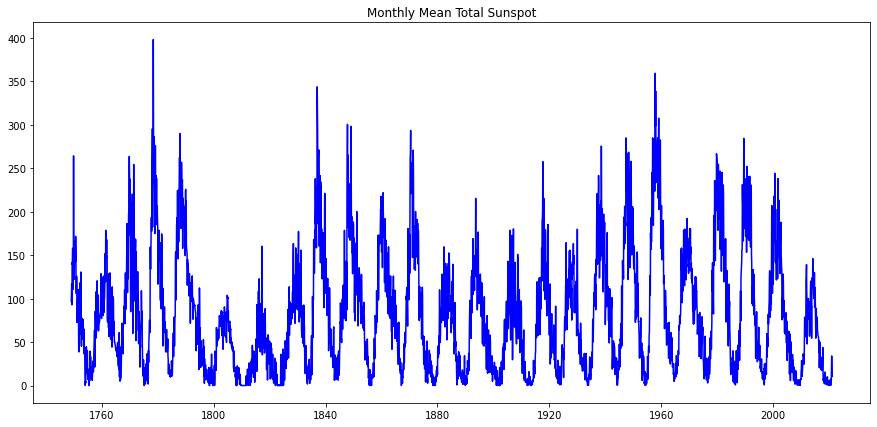

In [6]:
plt.figure(figsize=(15,7))
plt.plot(df,color='blue')
plt.title("Monthly Mean Total Sunspot")
plt.show()

In [7]:
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(df, autolag='AIC')
    else:
        adf_test = adfuller(df[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'n_lags: {adf_test[2]}')
    print(f'p-value: {adf_test[1]:.20f}')
    for key, value in adf_test[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    return test_result

In [8]:
adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns}
adf_test_results

ADF Statistic: -10.497051662546152
n_lags: 28
p-value: 0.00000000000000000111
Critial Values:
   1%, -3.4323724026124003
Critial Values:
   5%, -2.8624335760905684
Critial Values:
   10%, -2.5672456699774324


{'value': 'Stationary'}

In [9]:
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import dates as mpl_dates

In [10]:
def check_mean_std(ts, name):

    rolmean = ts.rolling(window=192).mean()
    rolstd = ts.rolling(window=192).std()
    plt.figure(figsize=(12,8))   
    print(name)
    
    plt.style.use('seaborn')
    plt.figure(figsize=(12,8))
    plt.plot(ts, color='red',label='Original')
    plt.plot(rolmean, color='black', label='Rolling Mean')
    plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d, %b, %Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    plt.xlabel("Date")
    plt.ylabel("SUNSPOT")
    plt.title('Log Scale Differeced SUNSPOT Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()



sunspot


<Figure size 864x576 with 0 Axes>

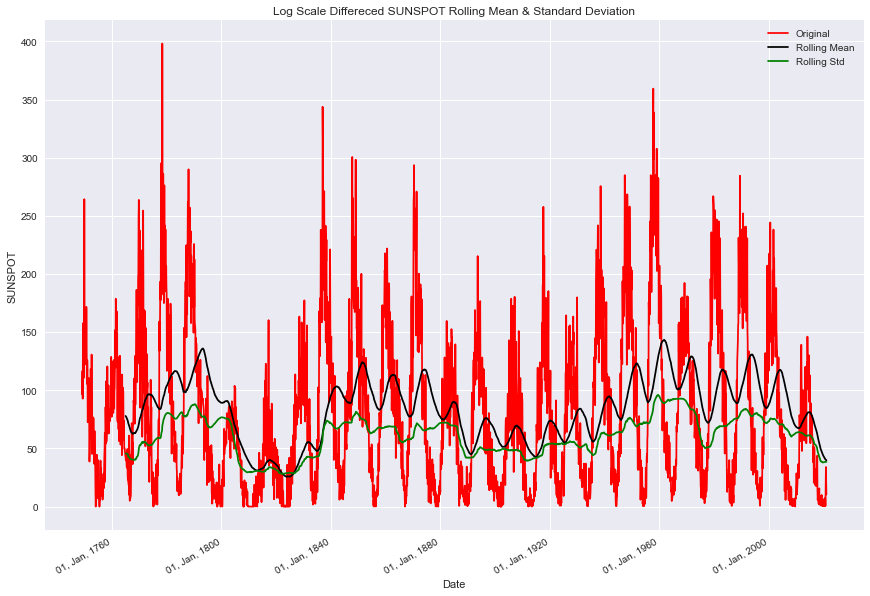

In [11]:
check_mean_std(df,'\n\nsunspot')

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, period = 365, model='additive')
seasonal, trend, resid = result.seasonal, result.trend, result.resid


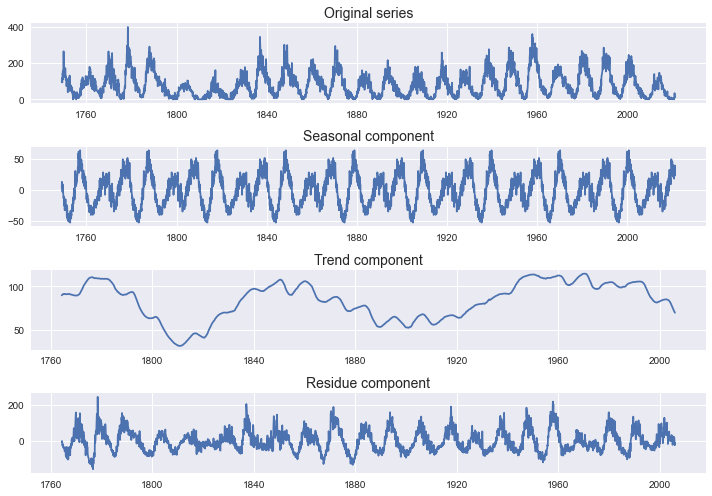

In [13]:
plot_data = [df, seasonal, trend, resid]
title_list = ['Original series', 'Seasonal component', 'Trend component', 'Residue component']
fig, axs = plt.subplots(len(plot_data), figsize=(10, 7))
for ax, data, title in zip(axs, plot_data, title_list):
    ax.plot(data)
    ax.set_title(title, fontsize=14)

plt.tight_layout()

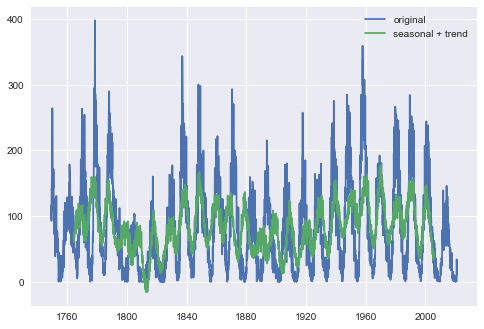

In [14]:
plt.plot(df, label="original", zorder=1)
plt.plot(trend + seasonal, label="seasonal + trend", zorder=2)
plt.legend(); plt.show()

<AxesSubplot:xlabel='time'>

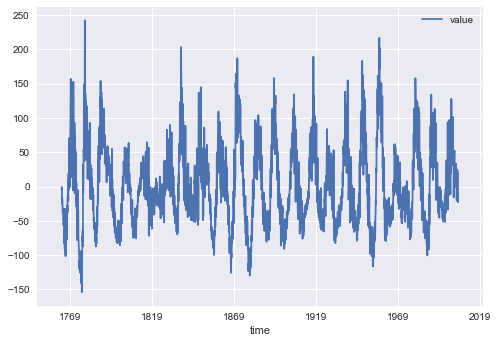

In [15]:
residue_df = pd.DataFrame(resid)
residue_df = residue_df.rename(columns={'resid': value_col})
residue_df.plot()

In [16]:
res_mean = resid.mean()
resid_std = resid.std()

lower_bound = res_mean - 4*resid_std
upper_bound = res_mean + 4*resid_std

In [17]:
def get_anomaly_array_using_cutoff_point(input_dataframe: pd.DataFrame, cutoff_point: float) -> np.ndarray:
    anomaly_array = np.array(input_dataframe[value_col] > cutoff_point)
    anomaly_array = np.where(anomaly_array == 0, np.nan, anomaly_array)
    return anomaly_array

def plot_data_anomalies(original_dataframe: pd.DataFrame, anomaly_array: list, ) -> None:
    plt.plot_date(original_dataframe.index, original_dataframe[value_col], linestyle='--', zorder=1)
    plt.scatter(original_dataframe.index, anomaly_array * original_dataframe[value_col],
                color='r', marker='D', zorder=2)

def detect_anomalies_using_mean_std_method(
        input_dataframe: pd.DataFrame, threshold: float = 3, plot_cutoff: bool = False) -> np.ndarray:
    input_dataframe[value_col] = input_dataframe[value_col].abs()
    mean = input_dataframe[value_col].mean()
    std = input_dataframe[value_col].std()
    cutoff_value = mean + threshold * std
    print(f"Mean value = {mean:.2f}, Standard deviation value = {std:.2f}, Cutoff value = {cutoff_value:.2f}")

    if plot_cutoff:
        plot_the_impact_of_cutoff_value(input_dataframe, cutoff_value)

    anomaly_array = get_anomaly_array_using_cutoff_point(input_dataframe, cutoff_value)
    return anomaly_array

def plot_the_impact_of_cutoff_value(input_dataframe: pd.DataFrame, cutoff_value: float) -> None:
    plt.plot(input_dataframe[value_col])
    plt.fill_between(
        input_dataframe.index, y1=0, y2=cutoff_value, alpha=0.2, color='green', linestyle='--', linewidth=2)
    

In [18]:
anomalies = df[(resid < lower_bound) | (resid > upper_bound)]

In [19]:
anomalies

,value
time,
1778-05-31,398.2


Mean value = 46.66, Standard deviation value = 33.89, Cutoff value = 148.34


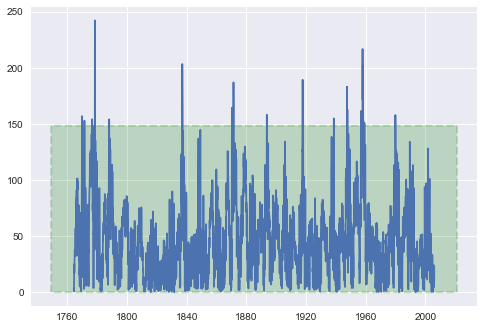

In [20]:
anomaly_array = detect_anomalies_using_mean_std_method(residue_df, plot_cutoff=True)

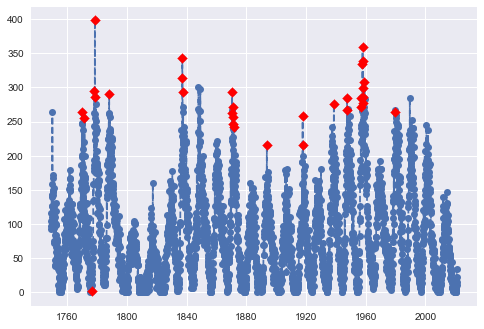

In [21]:
plot_data_anomalies(df, anomaly_array)

In [22]:
len(anomaly_array)

3265

In [23]:
#VAR Model

In [55]:
df = pd.read_csv('Sunspots.csv')

In [56]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [57]:
import datetime
from datetime import datetime

df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [58]:
df['Date'] = df['Date'].dt.strftime("%Y%m%d").astype(int)

In [59]:
df.head()

,Date,Monthly Mean Total Sunspot Number
0,17490131,96.7
1,17490228,104.3
2,17490331,116.7
3,17490430,92.8
4,17490531,141.7


In [60]:
from statsmodels.tsa.api import VAR

max_lag = 25
var_model = VAR(df)

In [61]:
results = var_model.select_order(max_lag)
lag = results.aic
print(lag)

24


In [62]:
def find_anomalies(squared_err):
    global cutoff
    predictions = (squared_err >= cutoff).astype(int)
    
    cutoff = np.mean(squared_err) + np.std(squared_err)
    
    return predictions, cutoff

In [63]:

model = var_model.fit(lag)
squared_err = model.resid.sum(axis=1) ** 2
predictions, cutoff = find_anomalies(squared_err)

In [64]:
df = df.iloc[lag:, :]
df['Preds'] = predictions.values

C:\Users\Sahishnuta\AppData\Local\Temp\ipykernel_3188\1712378839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Preds'] = predictions.values


In [65]:
df['Preds'].value_counts()

0    2995
1     246
Name: Preds, dtype: int64

In [66]:
df_anomaly = df[df['Preds'] == 1]

In [67]:
df_anomaly.head()

,Date,Monthly Mean Total Sunspot Number,Preds
25,17510228,72.5,1
32,17510930,39.2,1
38,17520331,118.3,1
42,17520731,130.7,1
43,17520831,48.8,1


# Prophet

In [9]:
time_col, value_col = 'time', 'value'
data_file='Sunspots.csv'
sunspot_date_col, sunspot_value_col = 'Date', 'Monthly Mean Total Sunspot Number'
sun_spot_col_dict = { sunspot_date_col: time_col, sunspot_value_col: value_col }

In [17]:
df=pd.read_csv(data_file,parse_dates=[sunspot_date_col])
df= df.rename(columns=sun_spot_col_dict)
df=df.set_index(time_col, drop=True)

In [18]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [19]:
df.head()

,value
time,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [22]:
df_prophet = df.reset_index().rename(columns={time_col: 'ds', value_col: 'y'}).copy()
df_prophet.head()

,ds,y
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [23]:
model = Prophet()
model.fit(df_prophet)

08:00:27 - cmdstanpy - INFO - Chain [1] start processing
08:00:28 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = model.make_future_dataframe(periods=0, freq='M', include_history=True)
future.tail()

,ds
3260,2020-09-30
3261,2020-10-31
3262,2020-11-30
3263,2020-12-31
3264,2021-01-31


In [25]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3260,2020-09-30,61.392968,-11.476965,156.267076,61.392968,61.392968,1.108134,1.108134,1.108134,1.108134,1.108134,1.108134,0.0,0.0,0.0,62.501102
3261,2020-10-31,61.322010,-14.595292,151.611621,61.322010,61.322010,1.096960,1.096960,1.096960,1.096960,1.096960,1.096960,0.0,0.0,0.0,62.418970
3262,2020-11-30,61.253340,-30.738741,148.836287,61.253340,61.253340,-1.988011,-1.988011,-1.988011,-1.988011,-1.988011,-1.988011,0.0,0.0,0.0,59.265328
3263,2020-12-31,61.182381,-26.759564,136.363729,61.182381,61.182381,-0.224220,-0.224220,-0.224220,-0.224220,-0.224220,-0.224220,0.0,0.0,0.0,60.958161
3264,2021-01-31,61.111422,-25.528116,139.261991,61.111422,61.111422,-3.215429,-3.215429,-3.215429,-3.215429,-3.215429,-3.215429,0.0,0.0,0.0,57.895993


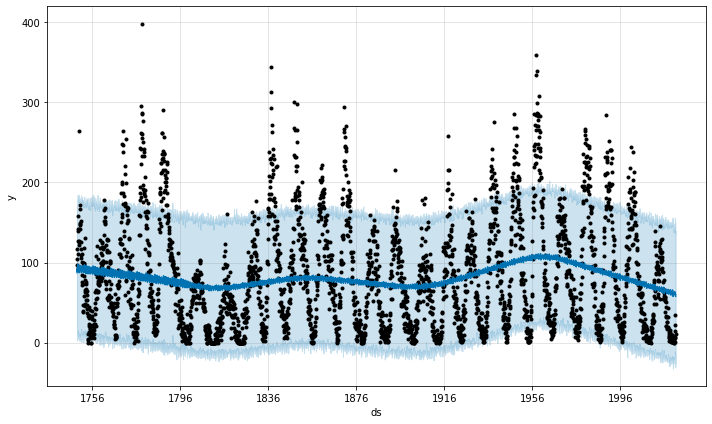

In [26]:
model.plot(forecast)
plt.show()

In [27]:
forecast["y"] = df_prophet["y"]
anomaly_array = np.array((forecast["y"] > forecast["yhat_upper"]) | (forecast["y"] < forecast["yhat_lower"]))
anomaly_array = np.where(anomaly_array==0, np.nan, anomaly_array)

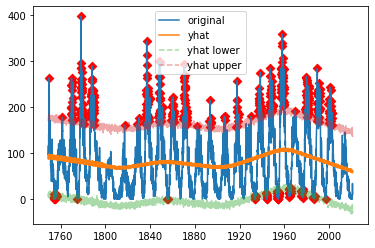

In [28]:
plt.plot(df_prophet.ds, df_prophet.y, label="original")
plt.plot(forecast.ds, forecast.yhat, label="yhat")

plt.plot(forecast.ds, forecast.yhat_lower, '--', label="yhat lower", alpha=0.4)
plt.plot(forecast.ds, forecast.yhat_upper, '--', label="yhat upper", alpha=0.4)

plt.scatter(df.index, anomaly_array * df[value_col], color='r', marker='D', zorder=2)

plt.legend(); plt.show()